In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import difflib

# Informacije o skupu podataka

Ovaj skup podataka sadrži informacije o saobraćajnim prekršajima iz svih elektronskih saobraćajnih prekršaja izdatih u okrugu. Bilo koja informacija koja se može koristiti za jedinstveno identifikovanje vozila, vlasnika vozila ili službenika koji izdaje prekršaj neće biti objavljena. 

Za ovu verziju, neke funkcije su uklonjene, a svi preostali karakteristični znakovi su kodirani kao nominalne faktorske promenljive. 
Svi znakovi interpunkcije su uklonjeni iz nivoa faktora. Promenljiva 'Violation.Type' se koristi kao cilj po podrazumevanim vrednostima. Manje ciljne kategorije 'SERO' i 'ESERO' su srušene u jednu kategoriju označenu kao 'SERO'. 

Skup podataka je smanjen na 5% originalne veličine. Neiskorišćeni nivoi faktora i nekoliko gotovo konstantnih funkcija su odbačeni.

# Učitavanje skupa podataka

In [86]:
data = pd.read_csv('../dataset/traffic_violations.csv')
rows, columns = data.shape
print(f'Broj redova: {rows}')
print(f'Broj kolona: {columns}')
print(f'Imena atributa: {list(data.columns)}')

Broj redova: 70340
Broj kolona: 21
Imena atributa: ['Description', 'Belts', 'Personal.Injury', 'Property.Damage', 'Commercial.License', 'Commercial.Vehicle', 'State', 'VehicleType', 'Year', 'Make', 'Model', 'Color', 'Charge', 'Contributed.To.Accident', 'Race', 'Gender', 'Driver.City', 'Driver.State', 'DL.State', 'Arrest.Type', 'Violation.Type']


Pogledajmo koje su sve jedinstvene vrednosti za atribute

In [87]:
pd.set_option("display.max_rows", 30)
pd.set_option("display.max_columns", 30)


all_columns = data.columns.to_list()

for i, column in enumerate(all_columns):
    temp = data.loc[:, column].unique()
    if len(temp) == 1:
        print (f"{i+1}. {column} sadrži {len(temp)} jedinstvenu vrednost: {temp}")
    else:
        print (f"{i+1}. {column} sadrži {len(temp)} jedinstvenih vrednosti: {temp}")

1. Description sadrži 2130 jedinstvenih vrednosti: ["'DISPLAYING EXPIRED REGISTRATION PLATE ISSUED BY ANY STATE'"
 "'DRIVER FAIL TO STOP AT RED TRAFFIC SIGNAL BEFORE RIGHT TURN'"
 "'DRIVING UNDER THE INFLUENCE OF ALCOHOL PER SE'" ...
 "'PARTS NOT SPECIFICALLY PROVIDED FORNOT IN SAFE OPERATING CONDITIONHEADER BOARD CRACKED'"
 "'fail to return card'"
 "'FAILURE TO MAINTAIN LEGIBLE REGISTRATION PLATE FREE FROM FOREIGN MATERIALSREAR TAG COVERED IN DIRT'"]
2. Belts sadrži 2 jedinstvenih vrednosti: ['No' 'Yes']
3. Personal.Injury sadrži 2 jedinstvenih vrednosti: ['No' 'Yes']
4. Property.Damage sadrži 2 jedinstvenih vrednosti: ['No' 'Yes']
5. Commercial.License sadrži 2 jedinstvenih vrednosti: ['No' 'Yes']
6. Commercial.Vehicle sadrži 2 jedinstvenih vrednosti: ['No' 'Yes']
7. State sadrži 58 jedinstvenih vrednosti: ['NC' 'MD' 'IL' 'PA' 'VA' 'DC' 'VT' 'LA' 'XX' 'WV' 'TX' 'MI' 'TN' 'CA'
 'DE' 'AL' 'WA' 'NJ' 'GA' 'US' 'MT' 'FL' 'KY' 'MN' 'OK' 'AK' 'IN' 'OH'
 'WI' 'NY' 'MA' 'AZ' 'IA' 'CT' 'SC' 'C

Možemo primetiti da atributi State, Year, Make i Model sadrže pogrešno unete podatke.

In [88]:
data.head()

,Description,Belts,Personal.Injury,Property.Damage,Commercial.License,Commercial.Vehicle,State,VehicleType,Year,Make,Model,Color,Charge,Contributed.To.Accident,Race,Gender,Driver.City,Driver.State,DL.State,Arrest.Type,Violation.Type
0,'DISPLAYING EXPIRED REGISTRATION PLATE ISSUED ...,No,No,No,No,No,NC,'02 - Automobile',2013,HYUNDAI,SONATA,GRAY,13411f,No,WHITE,F,ASHEVILLE,NC,NC,'A - Marked Patrol',Citation
1,'DRIVER FAIL TO STOP AT RED TRAFFIC SIGNAL BEF...,No,No,No,No,No,MD,'02 - Automobile',2015,FORD,FUSION,SILVER,21202i1,No,OTHER,M,'SILVER SPRING',MD,MD,'A - Marked Patrol',Citation
2,'DRIVING UNDER THE INFLUENCE OF ALCOHOL PER SE',No,No,No,No,No,MD,'02 - Automobile',2000,TOYOTA,CAMRY,BLACK,21902a2,No,BLACK,M,'SILVER SPRING',MD,MD,'B - Unmarked Patrol',Citation
3,'PERSON DRIVING MOTOR VEHICLE ON HIGHWAY OR PU...,No,No,No,No,No,MD,'02 - Automobile',2012,HOND,CROSSTOUR,BLACK,16303c,No,BLACK,M,COLUMBIA,MD,MD,'A - Marked Patrol',Citation
4,'DISPLAYING EXPIRED REGISTRATION PLATE ISSUED ...,No,No,No,Yes,No,MD,'02 - Automobile',2010,FORD,F250,BLACK,13411f,No,WHITE,M,'MOUNT AIRY',MD,MD,'A - Marked Patrol',Citation


In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70340 entries, 0 to 70339
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Description              70340 non-null  object
 1   Belts                    70340 non-null  object
 2   Personal.Injury          70340 non-null  object
 3   Property.Damage          70340 non-null  object
 4   Commercial.License       70340 non-null  object
 5   Commercial.Vehicle       70340 non-null  object
 6   State                    70340 non-null  object
 7   VehicleType              70340 non-null  object
 8   Year                     70340 non-null  object
 9   Make                     70340 non-null  object
 10  Model                    70340 non-null  object
 11  Color                    70340 non-null  object
 12  Charge                   70340 non-null  object
 13  Contributed.To.Accident  70340 non-null  object
 14  Race                     70340 non-nul

# Rad sa nedostajućim vrednostima

Proveravamo da li u skupu postoje nedostajuće vrednosti.

In [90]:
data.isna().any().any()

False

Primećujemo da se u skupu ne nalaze nedostajuće vrednosti.

Međutim, postoje instance označene sa '?'

In [91]:
print('Takve instance se nalaze u atributima:')

all_columns = data.columns.to_list()
for _, column in enumerate(all_columns):
    temp = data.loc[:, column].unique()
    for _, el in enumerate(temp):
        if el == '?':            
            print('\t', column)
            break

Takve instance se nalaze u atributima:
	 State
	 Year
	 Make
	 Model
	 Color
	 Driver.City
	 DL.State


Pretvorićemo ih u numpy.nan

In [92]:
data['State'] = data['State'].replace("?", np.nan)

In [93]:
data['Year'] = data['Year'].replace("?", np.nan)

In [94]:
data['Make'] = data['Make'].replace("?", np.nan)

In [95]:
data['Model'] = data['Model'].replace("?", np.nan)

In [96]:
data['Driver.City'] = data['Driver.City'].replace("?", np.nan)

In [97]:
data['DL.State'] = data['DL.State'].replace("?", np.nan)

Takođe, atribut Vehicle.Type sadrži unknown vrednost, pretvaramo je u np.nan

In [98]:
data['VehicleType'] = data['VehicleType'].replace("29 - Unknown", np.nan)

Instance koje u koloni Gender imaju vrednost 'U' posmatramo kao nepoznate vrednosti.
Konvertujemo ih u np.nan

In [99]:
data['Gender'] = data['Gender'].replace("U", np.nan)

In [100]:
data.isna().any().any()

True

Pogledajmo koliki udeo zauzimaju nedostujuće vrednosti.

In [101]:
def get_na_percent(data):
    total = data.shape[0]
    missing_columns = [col for col in data.columns if data[col].isna().sum() > 0]
    missing_percent = {}
    for col in missing_columns:
        na_count = data[col].isna().sum()
        per = (na_count/total) * 100
        missing_percent[col] = per
        print("{} : {} ({}%)".format(col, na_count, round(per, 3)))
    return missing_percent

missing_percent = get_na_percent(data)

State : 3 (0.004%)
Year : 434 (0.617%)
Make : 448 (0.637%)
Model : 455 (0.647%)
Gender : 90 (0.128%)
Driver.City : 8 (0.011%)
DL.State : 52 (0.074%)


Uklonićemo ih.

In [102]:
data.dropna(inplace=True)

In [103]:
data.isna().any().any()

False

# Analiza skupa podataka

Ciljna promenljiva je Contributed.To.Accident

Kodiraćemo vrednosti instanci binarnih kategoričkih klasa u 0 i 1.

In [104]:
data['Belts'] = data['Belts'].map({'No':0,'Yes':1})

In [105]:
data['Personal.Injury'] = data['Personal.Injury'].map({'No':0,'Yes':1})

In [106]:
data['Property.Damage'] = data['Property.Damage'].map({'No':0,'Yes':1})

In [107]:
data['Commercial.License'] = data['Commercial.License'].map({'No':0,'Yes':1})

In [108]:
data['Commercial.Vehicle'] = data['Commercial.Vehicle'].map({'No':0,'Yes':1})

In [109]:
data['Contributed.To.Accident'] = data['Contributed.To.Accident'].map({'No':0,'Yes':1})

In [110]:
data['Gender'] = data['Gender'].map({'M':0,'F':1})

In [111]:
data['Violation.Type'] = data['Violation.Type'].map({'Citation':0,'SERO':1,'Warning':2})

Atribut Charge nam nije od značaja, pa ćemo ga odbaciti.

In [112]:
data.drop('Charge', axis=1, inplace=True)

Kao ni boja automobila.

In [113]:
data.drop('Color', axis=1, inplace=True)

Kao ni grad odakle je vozač, obzirom da ima oko 1900 gradova.

In [114]:
data.drop('Driver.City', axis=1, inplace=True)

In [115]:
data.head()

,Description,Belts,Personal.Injury,Property.Damage,Commercial.License,Commercial.Vehicle,State,VehicleType,Year,Make,Model,Contributed.To.Accident,Race,Gender,Driver.State,DL.State,Arrest.Type,Violation.Type
0,'DISPLAYING EXPIRED REGISTRATION PLATE ISSUED ...,0,0,0,0,0,NC,'02 - Automobile',2013,HYUNDAI,SONATA,0,WHITE,1,NC,NC,'A - Marked Patrol',0
1,'DRIVER FAIL TO STOP AT RED TRAFFIC SIGNAL BEF...,0,0,0,0,0,MD,'02 - Automobile',2015,FORD,FUSION,0,OTHER,0,MD,MD,'A - Marked Patrol',0
2,'DRIVING UNDER THE INFLUENCE OF ALCOHOL PER SE',0,0,0,0,0,MD,'02 - Automobile',2000,TOYOTA,CAMRY,0,BLACK,0,MD,MD,'B - Unmarked Patrol',0
3,'PERSON DRIVING MOTOR VEHICLE ON HIGHWAY OR PU...,0,0,0,0,0,MD,'02 - Automobile',2012,HOND,CROSSTOUR,0,BLACK,0,MD,MD,'A - Marked Patrol',0
4,'DISPLAYING EXPIRED REGISTRATION PLATE ISSUED ...,0,0,0,1,0,MD,'02 - Automobile',2010,FORD,F250,0,WHITE,0,MD,MD,'A - Marked Patrol',0


Atributi State, Driver.State i DL.State deluju kao da govore istu stvar.
Pogledajmo zavisnost između sva tri atributa.

Koliko ima instanci kod kojih su vrednosti za sva tri atributa iste?

In [116]:
tmp = data[['State','Driver.State','DL.State']]
tmp

,State,Driver.State,DL.State
0,NC,NC,NC
1,MD,MD,MD
2,MD,MD,MD
3,MD,MD,MD
4,MD,MD,MD
...,...,...,...
70335,MD,MD,MD
70336,MD,MD,MD
70337,MD,WI,WI
70338,MD,MD,MD


In [117]:
ukupno = 0
razlicito = 0

for _, row in tmp.iterrows():
    if len(row.unique()) > 1:
        razlicito = razlicito + 1
    ukupno = ukupno + 1
    
print('Različitih instanci ima: ', razlicito/ukupno, ' %')

Različitih instanci ima:  0.11403169140316914  %


Kako ih se razlikuje jako malo, možemo ove tri kolone zameniti jednom.

In [118]:
data.drop('Driver.State', axis=1, inplace=True)

In [119]:
data.drop('DL.State', axis=1, inplace=True)

Preimenujmo kolone radi lakšeg rukovanja sa specifičnim funkcijama.

In [120]:
data = data.rename(columns={'Personal.Injury': 'PersonalInjury', 'Property.Damage': 'PropertyDamage', 'Commercial.License': 'CommercialLicense', 'Commercial.Vehicle': 'CommercialVehicle', 'Contributed.To.Accident': 'ContributedToAccident', 'Driver.City': 'DriverCity', 'Arrest.Type': 'ArrestType', 'Violation.Type': 'ViolationType'})

In [121]:
data.head()

,Description,Belts,PersonalInjury,PropertyDamage,CommercialLicense,CommercialVehicle,State,VehicleType,Year,Make,Model,ContributedToAccident,Race,Gender,ArrestType,ViolationType
0,'DISPLAYING EXPIRED REGISTRATION PLATE ISSUED ...,0,0,0,0,0,NC,'02 - Automobile',2013,HYUNDAI,SONATA,0,WHITE,1,'A - Marked Patrol',0
1,'DRIVER FAIL TO STOP AT RED TRAFFIC SIGNAL BEF...,0,0,0,0,0,MD,'02 - Automobile',2015,FORD,FUSION,0,OTHER,0,'A - Marked Patrol',0
2,'DRIVING UNDER THE INFLUENCE OF ALCOHOL PER SE',0,0,0,0,0,MD,'02 - Automobile',2000,TOYOTA,CAMRY,0,BLACK,0,'B - Unmarked Patrol',0
3,'PERSON DRIVING MOTOR VEHICLE ON HIGHWAY OR PU...,0,0,0,0,0,MD,'02 - Automobile',2012,HOND,CROSSTOUR,0,BLACK,0,'A - Marked Patrol',0
4,'DISPLAYING EXPIRED REGISTRATION PLATE ISSUED ...,0,0,0,1,0,MD,'02 - Automobile',2010,FORD,F250,0,WHITE,0,'A - Marked Patrol',0


In [122]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69735 entries, 0 to 70339
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Description            69735 non-null  object
 1   Belts                  69735 non-null  int64 
 2   PersonalInjury         69735 non-null  int64 
 3   PropertyDamage         69735 non-null  int64 
 4   CommercialLicense      69735 non-null  int64 
 5   CommercialVehicle      69735 non-null  int64 
 6   State                  69735 non-null  object
 7   VehicleType            69735 non-null  object
 8   Year                   69735 non-null  object
 9   Make                   69735 non-null  object
 10  Model                  69735 non-null  object
 11  ContributedToAccident  69735 non-null  int64 
 12  Race                   69735 non-null  object
 13  Gender                 69735 non-null  int64 
 14  ArrestType             69735 non-null  object
 15  ViolationType      

## Raspodela vozača po državama

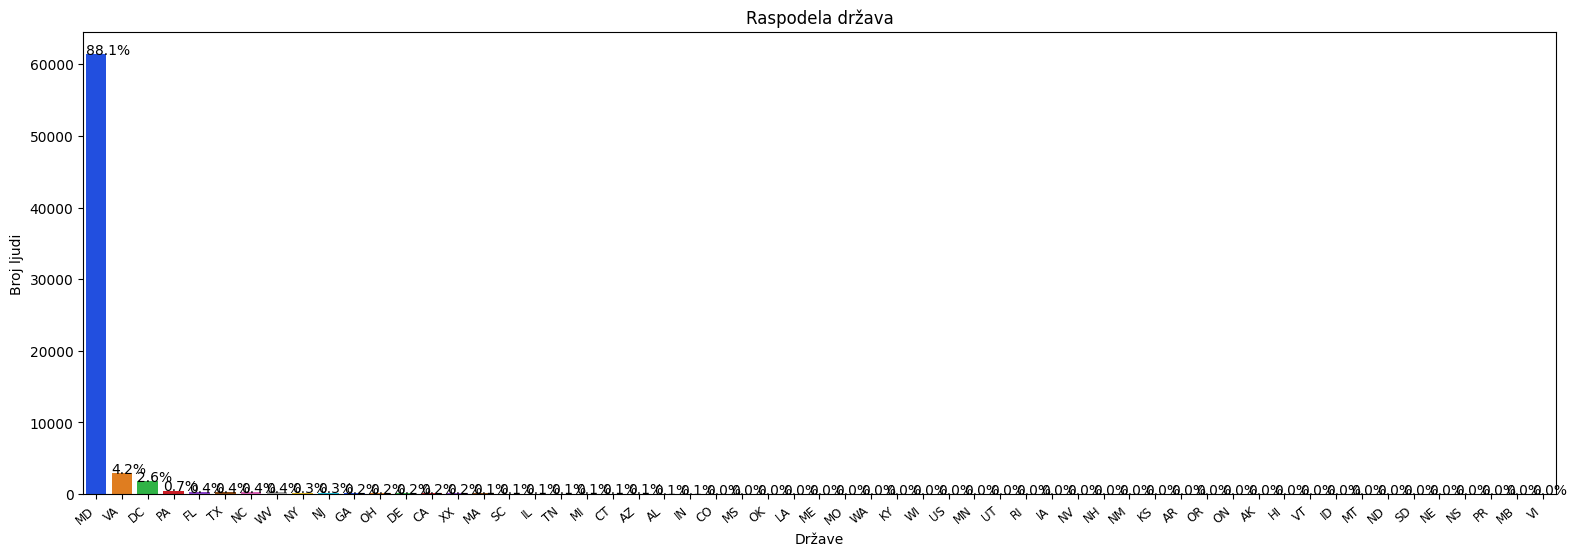

In [123]:
fig , ax = plt.subplots(figsize=(19,6))
ax = sns.countplot(x = data.State, data = data, order = data.State.value_counts().index, palette = "bright")
for i in ax.patches:
    percentage = 100*i.get_height()/len(data.State)
    percentage_str = '{:.1f}%'.format(percentage)
    x = i.get_x()
    y = i.get_height()
    ax.annotate(percentage_str, (x, y))
    
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 8.5)
plt.title("Raspodela država")
plt.xlabel("Države")
plt.ylabel("Broj ljudi");

Sa grafika vidimo da su prve tri države najzastupljenije među svim ostalim državama.

Kako imamo previše nedostajućih vrednosti i preveliku nebalansiranost unutar klase, obrisaćemo ovu kolonu.

In [124]:
data.drop('State', axis=1, inplace=True)

## Raspodela podataka po godinama

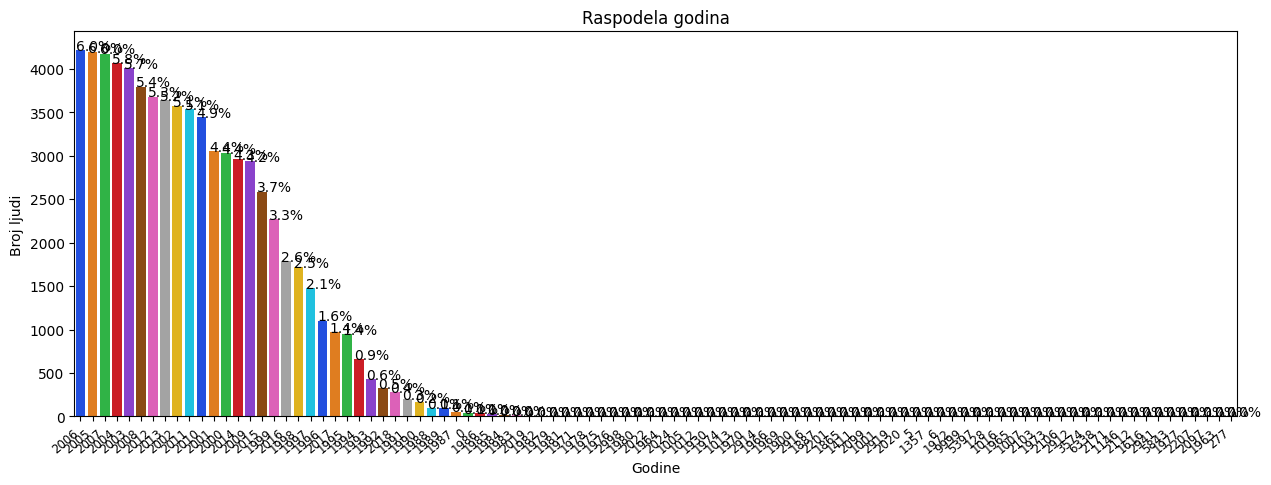

In [125]:
fig , ax = plt.subplots(figsize=(15,5))
ax = sns.countplot(x = data.Year, data = data, order = data.Year.value_counts().index, palette = "bright")
for i in ax.patches:
    percentage = '{:.1f}%'.format(100*i.get_height()/len(data.Year))
    x = i.get_x()
    y = i.get_height()
    ax.annotate(percentage, (x, y))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 8.5)
plt.title("Raspodela godina")
plt.xlabel("Godine")
plt.ylabel("Broj ljudi");

Otprilike trećina zabeleženih godina se najviše javlja, za njih smatramo da su ispravno unete.

Ostale godine su unete greškom i ne predstavljaju realne vrednosti.

## Raspodela načina hapšenja

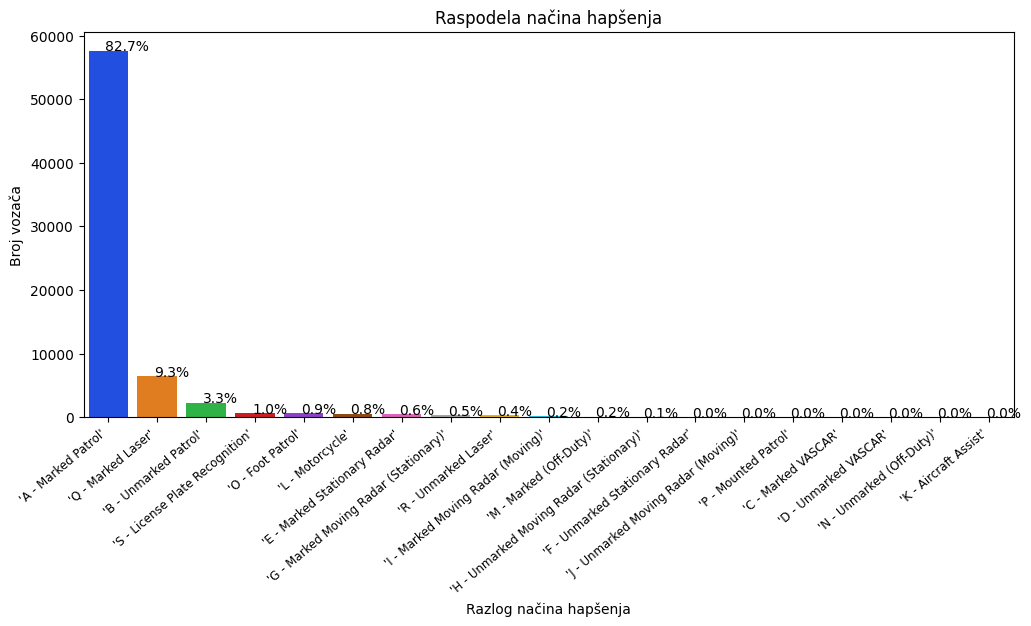

In [126]:
fig , ax = plt.subplots(figsize=(12,5))
ax = sns.countplot(x = data.ArrestType, data = data, order = data.ArrestType.value_counts().index, palette = "bright")
for i in ax.patches:
    percentage = '{:.1f}%'.format(100*i.get_height()/len(data.ArrestType))
    x = i.get_x()
    y = i.get_height()
    ax.annotate(percentage, (x+0.34, y))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 8.5)
plt.title("Raspodela načina hapšenja")
plt.xlabel("Razlog načina hapšenja")
plt.ylabel("Broj vozača");

# Sređivanje pogrešno unetih podataka

U skupu postoji velika količina pogrešno unetih podataka u kolonama:
    
    State
    Year
    Make
    Model
    ArrestType (nebalansiranost)

## Način hapšenja

In [127]:
data['ArrestType'].unique()

array(["'A - Marked Patrol'", "'B - Unmarked Patrol'",
       "'S - License Plate Recognition'", "'Q - Marked Laser'",
       "'L - Motorcycle'", "'O - Foot Patrol'", "'R - Unmarked Laser'",
       "'M - Marked (Off-Duty)'", "'E - Marked Stationary Radar'",
       "'G - Marked Moving Radar (Stationary)'",
       "'I - Marked Moving Radar (Moving)'",
       "'H - Unmarked Moving Radar (Stationary)'", "'P - Mounted Patrol'",
       "'N - Unmarked (Off-Duty)'", "'D - Unmarked VASCAR'",
       "'J - Unmarked Moving Radar (Moving)'",
       "'F - Unmarked Stationary Radar'", "'C - Marked VASCAR'",
       "'K - Aircraft Assist'"], dtype=object)

Sa prethodnog grafika možemo videti da vrednosti A, Q, B zauzimaju preko 95 % u odnosu na sve načine hapšenja.

Suzićemo načine hapšenja na ove tri vrednosti. Promenimo im imena radi lakše obrade.

In [128]:
data['ArrestType'].replace({"'A - Marked Patrol'" : "Marked Patrol", "'B - Unmarked Patrol'" : "Unmarked Patrol", "'Q - Marked Laser'" : "Marked Laser"}, inplace=True)

In [129]:
data['ArrestType'].unique()

array(['Marked Patrol', 'Unmarked Patrol',
       "'S - License Plate Recognition'", 'Marked Laser',
       "'L - Motorcycle'", "'O - Foot Patrol'", "'R - Unmarked Laser'",
       "'M - Marked (Off-Duty)'", "'E - Marked Stationary Radar'",
       "'G - Marked Moving Radar (Stationary)'",
       "'I - Marked Moving Radar (Moving)'",
       "'H - Unmarked Moving Radar (Stationary)'", "'P - Mounted Patrol'",
       "'N - Unmarked (Off-Duty)'", "'D - Unmarked VASCAR'",
       "'J - Unmarked Moving Radar (Moving)'",
       "'F - Unmarked Stationary Radar'", "'C - Marked VASCAR'",
       "'K - Aircraft Assist'"], dtype=object)

In [130]:
arrest_types = ["Marked Patrol", "Unmarked Patrol", "Marked Laser"]

Sve načine hapšenja koji ne pripadaju izdvojenim ćemo zameniti sa nasumično odabranim načinom iz izdvojenih.

In [131]:
import random

data_size = data.shape[0]
types_size = len(arrest_types)
tmp = []

i = 0
while i < data_size:
    if data['ArrestType'].iloc[i] not in arrest_types:
        random_index = random.randint(0, types_size - 1)
        tmp.append(arrest_types[random_index])
    else:
        tmp.append(data['ArrestType'].iloc[i])
    i = i + 1
    
data['ArrestType'] = tmp
data['ArrestType'].unique()

array(['Marked Patrol', 'Unmarked Patrol', 'Marked Laser'], dtype=object)

## Marke vozila

In [132]:
data['Make'].unique()

array(['HYUNDAI', 'FORD', 'TOYOTA', 'HOND', 'MAZDA', 'HONDA', 'CHRYSLER',
       'CHRY', 'VOLK', 'GEO', 'KIA', 'CHEV', 'INFINITI', 'LEXUS', 'ACURA',
       'DODGE', 'NISS', 'BMW', 'LINC', 'TOYT', 'UNKNOWN', 'CHEVY',
       'CHEVEROLET', 'JEEP', 'MITSUBISHI', 'GMC', 'PETE', 'CHEVROLET',
       'MERCEDES', 'NISSAN', 'ACUR', 'MOTORIZED', 'MINI', 'MITI',
       'CADILLAC', 'SUBARU', 'VOLVO', 'SATURN', 'SUBA', 'MERZ', 'AUDI',
       'MERCURY', 'HYUN', 'ISUZU', 'YAMAHA', 'CADI', 'SCION', 'BUICK',
       'LINCOLN', 'LEXU', 'DODG', 'KENWORTH', 'LINCLN', 'VW', 'RAM',
       'BUIC', 'FRIGHTLINER', 'INFI', 'BWM', "'MERZ BENZ'", 'VOLV',
       'LEXS', 'MAZD', 'TOYO', 'ISU', 'MERC', 'MITS', 'DUCATI',
       "'LAND ROVER'", 'VOLKSWAGEN', 'VOLV0', 'VOLKS', 'PONTIAC', 'SAT',
       'MITZ', 'MECURY', "'RANGE ROVER'", 'INTERNATIONAL', 'SAAB',
       'PORSCHE', 'VOLSWAGEN', 'HYUND', 'TPYPTA', 'SUZI', 'VOLKSWAGON',
       'CHRYS', "'FIVE STAR'", 'SATU', 'CEHVY', 'PONT', 'INTL', 'INFINIT',
       'TOTY', '

Ove pogrešne vrednosti ćemo pretvoriti u njima slične, npr. Subar u Subaru, Toyotta u Toyota itd.

In [133]:
correct_names = ['TOYOTA', 'MAZDA', 'SUBARU', 'MITSUBISHI', 'MERCEDES', 'CADILLAC', 'VOLKSWAGEN', 'SUBARU', 'BMW', 'AUDI', 'CHEVROLET', 'KIA', 'INFINITI', 'LEXUS', 'YAMAHA', 'JEEP', 'NISSAN', 'SATURN', 'FORD', 'DODGE', 'ACURA', 'DUCATI', 'CHRYSLER', 'GEO', 'GMC', 'Mercury']

x = [next(iter(x), np.nan) 
          for x in map(lambda x: difflib.get_close_matches(x, correct_names, cutoff = 0.3), data.Make)]
data['Make'] = x

In [134]:
data['Make'].unique()

array(['DUCATI', 'FORD', 'TOYOTA', 'MAZDA', 'CHRYSLER', 'VOLKSWAGEN',
       'GEO', 'KIA', 'CHEVROLET', 'INFINITI', 'LEXUS', 'ACURA', 'DODGE',
       'NISSAN', 'BMW', 'JEEP', 'MITSUBISHI', 'GMC', 'MERCEDES',
       'CADILLAC', 'SUBARU', 'SATURN', 'AUDI', 'YAMAHA', nan],
      dtype=object)

In [135]:
len(data['Make'])

69735

In [136]:
data['Make'].isna().sum()

101

Ostala je 101 instanca bez vrednosti. Kako je to jako mali broj instanci, obrisaćemo ih.

In [137]:
data = data.dropna()

In [138]:
data['Make'].isna().sum()

0

## Modeli vozila

In [139]:
data['Model']

0           SONATA
1           FUSION
2            CAMRY
3        CROSSTOUR
4             F250
           ...    
70335        CAMRY
70336        ES350
70337      TRIBUTE
70338      CONVERT
70339           4S
Name: Model, Length: 69634, dtype: object

Pogledajmo frekvenciju pojavljivanja modela.

In [140]:
model_frequency = dict()
models = data['Model']

for model in models:
    if model in model_frequency:
        model_frequency[model] = model_frequency[model] + 1
    else:
        model_frequency[model] = 1

model_frequency
model_frequency = {key: val for key, val in sorted(model_frequency.items(), key = lambda ele: ele[1], reverse = True)}
print(model_frequency)

{'4S': 7769, 'TK': 4566, 'ACCORD': 2686, 'CIVIC': 2387, 'CAMRY': 2369, 'COROLLA': 2128, 'ALTIMA': 1355, '2S': 1190, '4D': 1176, 'SUV': 1080, '4DR': 949, 'VN': 885, 'VAN': 757, 'CRV': 742, 'RAV4': 619, 'SENTRA': 589, 'EXPLORER': 584, 'F150': 562, 'ODYSSEY': 510, 'SONATA': 507, 'MAXIMA': 504, 'SW': 497, 'SIENNA': 492, 'ELANTRA': 483, 'JETTA': 472, 'PRIUS': 466, 'TRUCK': 441, 'HIGHLANDER': 433, 'PILOT': 421, 'TL': 413, 'IMPALA': 410, 'FOCUS': 408, 'SU': 363, 'MALIBU': 344, 'MUSTANG': 342, 'CHARGER': 315, 'ESCAPE': 282, 'AVALON': 271, 'TACOMA': 266, 'MDX': 266, 'FUSION': 265, '4RUNNER': 252, 'VERSA': 251, '3': 249, 'SILVERADO': 245, 'TAHOE': 237, "'4 DOOR'": 234, 'EXPEDITION': 232, 'PASSAT': 229, 'ROGUE': 226, 'SUBURBAN': 218, '2D': 214, 'TAURUS': 213, 'CARAVAN': 208, 'EXPRESS': 202, 'A4': 196, '300': 194, 'CHEROKEE': 191, 'TSX': 188, 'E350': 186, '2DR': 174, 'CN': 168, 'OUTBACK': 164, 'TUNDRA': 162, 'MURANO': 159, 'GALANT': 158, 'YUKON': 151, 'WRANGLER': 149, 'PATHFINDER': 148, 'OPTIMA': 

Možemo primetiti da se veliki broj instanci javlja malo puta, pa ćemo izabrati samo one koje se javljaju preko 200 puta.

In [141]:
counter = 0
for num in model_frequency.values():
    if num > 200:
        counter = counter + 1
        
counter

55

Pretvorimo izabrane modele u listu.

In [142]:
counter_2 = 0
models = []
for key in model_frequency.keys():
    models.append(key)
    counter_2 = counter_2 + 1 
    if counter_2 == counter:
        break
        
del model_frequency

models

['4S',
 'TK',
 'ACCORD',
 'CIVIC',
 'CAMRY',
 'COROLLA',
 'ALTIMA',
 '2S',
 '4D',
 'SUV',
 '4DR',
 'VN',
 'VAN',
 'CRV',
 'RAV4',
 'SENTRA',
 'EXPLORER',
 'F150',
 'ODYSSEY',
 'SONATA',
 'MAXIMA',
 'SW',
 'SIENNA',
 'ELANTRA',
 'JETTA',
 'PRIUS',
 'TRUCK',
 'HIGHLANDER',
 'PILOT',
 'TL',
 'IMPALA',
 'FOCUS',
 'SU',
 'MALIBU',
 'MUSTANG',
 'CHARGER',
 'ESCAPE',
 'AVALON',
 'TACOMA',
 'MDX',
 'FUSION',
 '4RUNNER',
 'VERSA',
 '3',
 'SILVERADO',
 'TAHOE',
 "'4 DOOR'",
 'EXPEDITION',
 'PASSAT',
 'ROGUE',
 'SUBURBAN',
 '2D',
 'TAURUS',
 'CARAVAN',
 'EXPRESS']

Sve modele koji ne pripadaju izdvojenim ćemo zameniti u jedan od izdvojenih, nasumično.

In [143]:
data_size = data.shape[0]
models_size = len(models)
tmp = []

i = 0
while i < data_size:
    if data['Model'].iloc[i] not in models:
        random_index = random.randint(0, models_size - 1)
        tmp.append(models[random_index])
    else:
        tmp.append(data['Model'].iloc[i])
    i = i + 1
    
data['Model'] = tmp
data['Model'].unique()

array(['SONATA', 'FUSION', 'CAMRY', 'TRUCK', 'ODYSSEY', "'4 DOOR'", 'TK',
       '4S', '3', '4D', 'JETTA', '4DR', 'FOCUS', 'EXPEDITION', 'COROLLA',
       'MALIBU', 'PRIUS', 'TAHOE', 'ACCORD', '2S', 'HIGHLANDER', 'SUV',
       'ELANTRA', 'TACOMA', 'F150', 'CIVIC', 'TAURUS', 'IMPALA',
       'EXPRESS', 'SUBURBAN', 'CRV', 'RAV4', 'SILVERADO', 'MUSTANG',
       'EXPLORER', 'ROGUE', 'TL', 'ALTIMA', 'MDX', 'SU', 'SW', 'ESCAPE',
       'PILOT', 'MAXIMA', 'SIENNA', 'VAN', 'VN', 'SENTRA', 'AVALON',
       'CHARGER', 'PASSAT', '2D', 'CARAVAN', 'VERSA', '4RUNNER'],
      dtype=object)

## Godine

In [144]:
data['Year']

0        2013
1        2015
2        2000
3        2012
4        2010
         ... 
70335    2013
70336    2012
70337    2005
70338    2005
70339    2003
Name: Year, Length: 69634, dtype: object

Pogledajmo frekvenciju pojavljivanja godina.

In [145]:
year_frequency = dict()
years = data['Year']

for year in years:
    if year in year_frequency:
        year_frequency[year] = year_frequency[year] + 1
    else:
        year_frequency[year] = 1

year_frequency
year_frequency = {key: val for key, val in sorted(year_frequency.items(), key = lambda ele: ele[1], reverse = True)}
print(year_frequency)

{'2006': 4209, '2005': 4188, '2007': 4168, '2004': 4061, '2003': 4003, '2008': 3786, '2012': 3672, '2013': 3633, '2002': 3565, '2011': 3535, '2010': 3433, '2001': 3054, '2000': 3033, '2014': 2961, '2009': 2931, '2015': 2577, '1999': 2268, '2016': 1781, '1998': 1720, '1997': 1475, '1996': 1102, '2017': 968, '1995': 943, '1994': 659, '1993': 434, '1992': 328, '2018': 281, '1991': 201, '1990': 169, '1988': 100, '1989': 100, '1987': 56, '1986': 37, '0': 36, '1985': 28, '1984': 17, '1983': 13, '1982': 8, '2019': 8, '1979': 7, '1981': 5, '1971': 4, '1978': 4, '1975': 3, '1976': 3, '2998': 3, '1013': 2, '1970': 2, '2914': 2, '1900': 2, '1974': 2, '1969': 2, '1966': 2, '1012': 2, '1005': 2, '2024': 2, '1980': 2, '2022': 2, '1964': 2, '1930': 2, '1001': 1, '1016': 1, '2207': 1, '2912': 1, '2916': 1, '2103': 1, '1973': 1, '2106': 1, '3574': 1, '6338': 1, '2171': 1, '1146': 1, '2112': 1, '1616': 1, '2941': 1, '5843': 1, '1977': 1, '2097': 1, '1963': 1, '1965': 1, '1007': 1, '2020': 1, '1887': 1, 

Možemo primetiti da se veliki broj instanci javlja malo puta, pa ćemo izabrati samo one koje se javljaju preko 100 puta.

In [146]:
counter = 0
for num in year_frequency.values():
    if num >= 100:
        counter = counter + 1
        
counter

31

Pretvorimo izabrane godine u listu.

In [147]:
counter_2 = 0
years = []
for key in year_frequency.keys():
    years.append(key)
    counter_2 = counter_2 + 1 
    if counter_2 == counter:
        break
        
del year_frequency
years

['2006',
 '2005',
 '2007',
 '2004',
 '2003',
 '2008',
 '2012',
 '2013',
 '2002',
 '2011',
 '2010',
 '2001',
 '2000',
 '2014',
 '2009',
 '2015',
 '1999',
 '2016',
 '1998',
 '1997',
 '1996',
 '2017',
 '1995',
 '1994',
 '1993',
 '1992',
 '2018',
 '1991',
 '1990',
 '1988',
 '1989']

In [148]:
data_size = data.shape[0]
years_size = len(years)
tmp = []

i = 0
while i < data_size:
    if data['Year'].iloc[i] not in years:
        random_index = random.randint(0, years_size - 1)
        tmp.append(years[random_index])
    else:
        tmp.append(data['Year'].iloc[i])
    i = i + 1

data['Year'] = tmp    
data['Year'].unique()

array(['2013', '2015', '2000', '2012', '2010', '2007', '1998', '2011',
       '2004', '2016', '1994', '2006', '1999', '2002', '2003', '2001',
       '1996', '2014', '2008', '1993', '2017', '2005', '2009', '1997',
       '1995', '1988', '1989', '1991', '1992', '2018', '1990'],
      dtype=object)

# Zavisnost između atributa

In [149]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69634 entries, 0 to 70339
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Description            69634 non-null  object
 1   Belts                  69634 non-null  int64 
 2   PersonalInjury         69634 non-null  int64 
 3   PropertyDamage         69634 non-null  int64 
 4   CommercialLicense      69634 non-null  int64 
 5   CommercialVehicle      69634 non-null  int64 
 6   VehicleType            69634 non-null  object
 7   Year                   69634 non-null  object
 8   Make                   69634 non-null  object
 9   Model                  69634 non-null  object
 10  ContributedToAccident  69634 non-null  int64 
 11  Race                   69634 non-null  object
 12  Gender                 69634 non-null  int64 
 13  ArrestType             69634 non-null  object
 14  ViolationType          69634 non-null  int64 
dtypes: int64(8), object

In [150]:
num_cols = [col for col in data.columns if data[col].dtype != 'object']
num_cols

['Belts',
 'PersonalInjury',
 'PropertyDamage',
 'CommercialLicense',
 'CommercialVehicle',
 'ContributedToAccident',
 'Gender',
 'ViolationType']

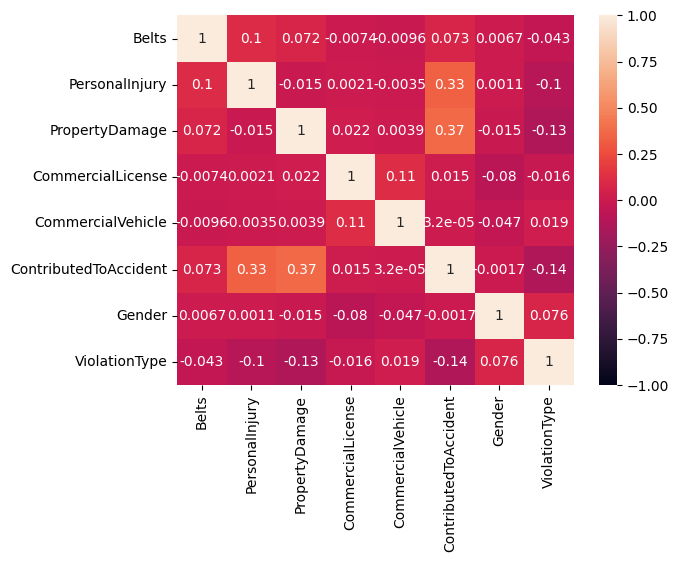

In [151]:
corr = data[num_cols].corr()
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)

## Raspodela polova

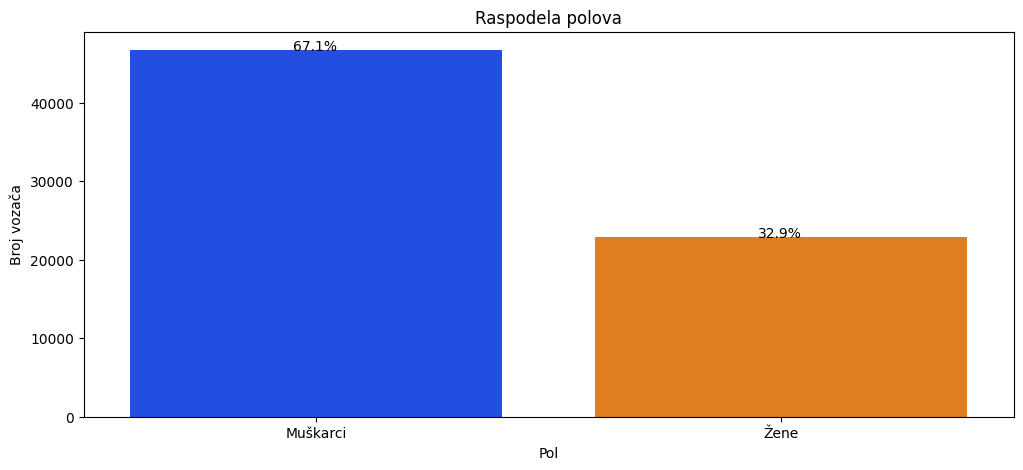

In [152]:
fig , ax = plt.subplots(figsize=(12,5))
ax = sns.countplot(x = data.Gender, data = data, order = data.Gender.value_counts().index, palette = "bright")
for i in ax.patches:
    percentage = '{:.1f}%'.format(100*i.get_height()/len(data.Gender))
    x = i.get_x()
    y = i.get_height()
    ax.annotate(percentage, (x+0.35, y))
ax.set_xticklabels(['Muškarci', 'Žene'])
plt.title("Raspodela polova")
plt.xlabel("Pol")
plt.ylabel("Broj vozača");

## Odnos pola i broja saobraćajnih nezgoda

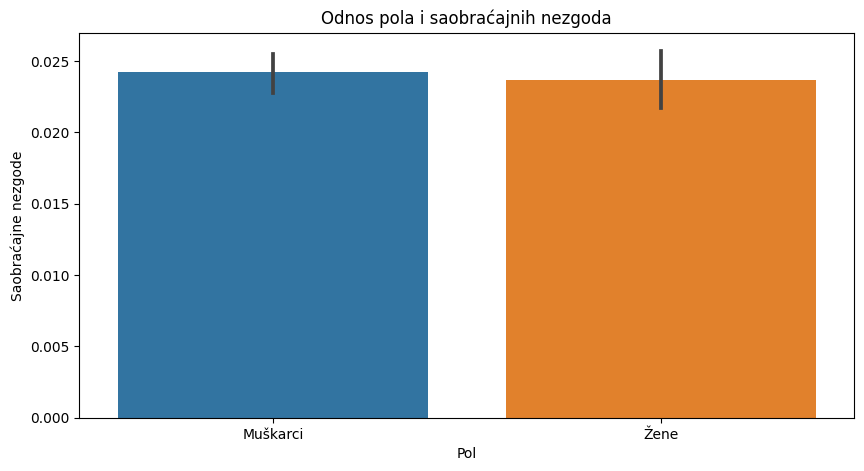

In [153]:
plt.figure(figsize=(10,5))
g = sns.barplot(x='Gender', y='ContributedToAccident', data=data)
g.set_xticklabels(['Muškarci', 'Žene'])
plt.title('Odnos pola i saobraćajnih nezgoda')
plt.xlabel('Pol')
plt.ylabel('Saobraćajne nezgode')
plt.show()

## Raspodela tipa prekršaja

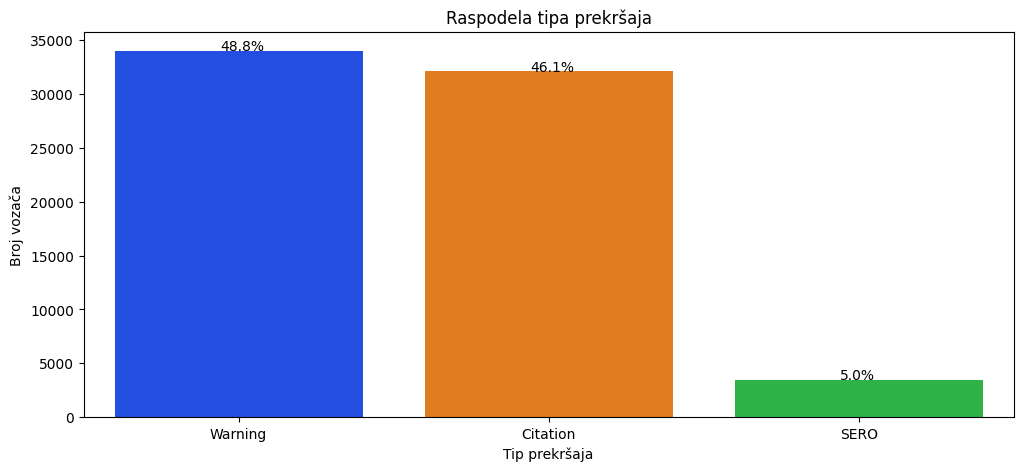

In [154]:
fig , ax = plt.subplots(figsize=(12,5))
ax = sns.countplot(x = data.ViolationType, data = data, order = data.ViolationType.value_counts().index, palette = "bright")
for i in ax.patches:
    percentage = '{:.1f}%'.format(100*i.get_height()/len(data.ViolationType))
    x = i.get_x()
    y = i.get_height()
    ax.annotate(percentage, (x+0.34, y))
ax.set_xticklabels(['Warning', 'Citation', 'SERO'])
plt.title("Raspodela tipa prekršaja")
plt.xlabel("Tip prekršaja")
plt.ylabel("Broj vozača");

## Raspodela rasa

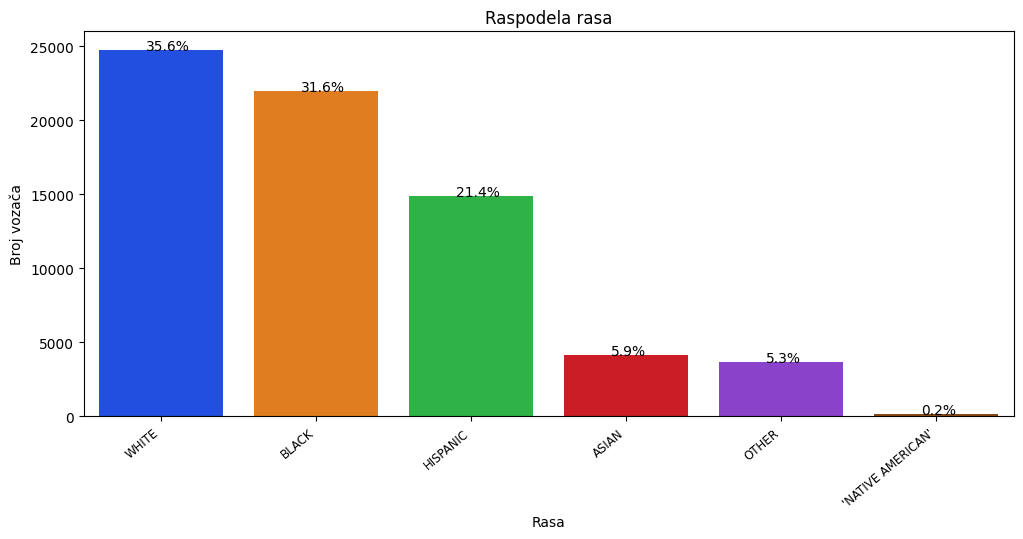

In [155]:
fig , ax = plt.subplots(figsize=(12,5))
ax = sns.countplot(x = data.Race, data = data, order = data.Race.value_counts().index, palette = "bright")
for i in ax.patches:
    percentage = '{:.1f}%'.format(100*i.get_height()/len(data.Race))
    x = i.get_x()
    y = i.get_height()
    ax.annotate(percentage, (x+0.30, y))
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize = 8.5)
plt.title("Raspodela rasa")
plt.xlabel("Rasa")
plt.ylabel("Broj vozača");

## Odnos rase i broja saobraćajnih nezgoda

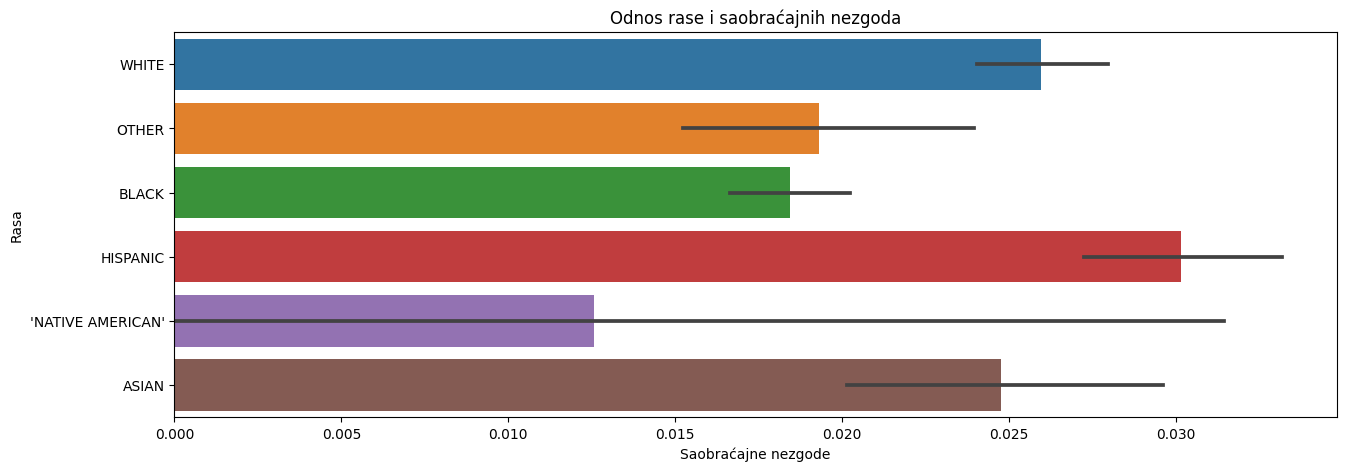

In [156]:
plt.figure(figsize=(15,5))
sns.barplot(x='ContributedToAccident', y='Race', data=data)
plt.title('Odnos rase i saobraćajnih nezgoda')
plt.ylabel('Rasa')
plt.xlabel('Saobraćajne nezgode')
plt.show()

## Odnos godina i broja saobraćajnih nezgoda

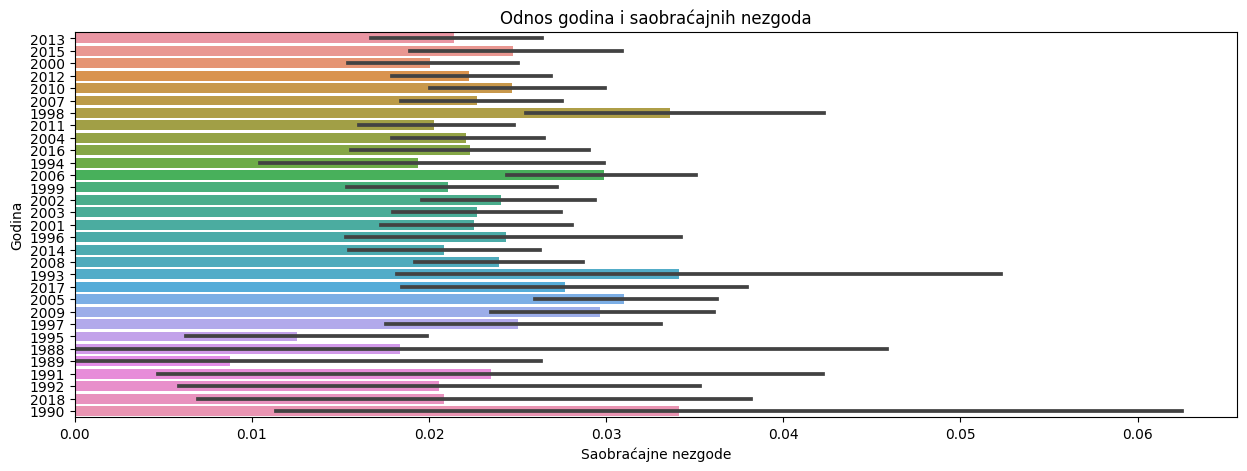

In [157]:
plt.figure(figsize=(15,5))
sns.barplot(x='ContributedToAccident', y='Year', data=data)
plt.title('Odnos godina i saobraćajnih nezgoda')
plt.ylabel('Godina')
plt.xlabel('Saobraćajne nezgode')
plt.show()

## Odnos službenih vozila i povreda vozača

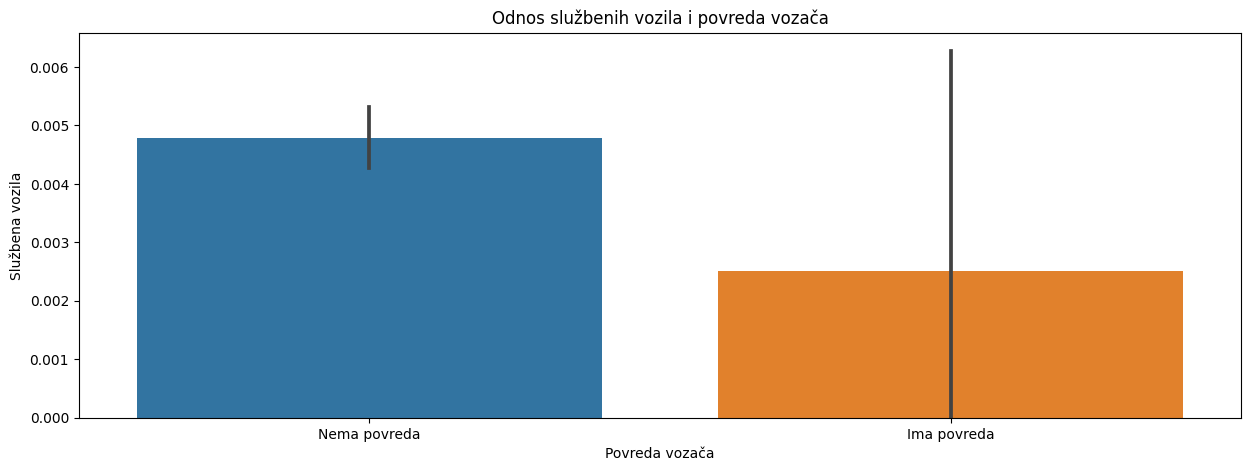

In [158]:
plt.figure(figsize=(15,5))
g = sns.barplot(x='PersonalInjury', y='CommercialVehicle', data=data)
g.set_xticklabels(['Nema povreda', 'Ima povreda'])
plt.title('Odnos službenih vozila i povreda vozača')
plt.ylabel('Službena vozila')
plt.xlabel('Povreda vozača')
plt.show()

# Priprema za klasifikaciju i klasterovanje

In [159]:
data.drop('Description', axis=1, inplace=True)
data.head()

,Belts,PersonalInjury,PropertyDamage,CommercialLicense,CommercialVehicle,VehicleType,Year,Make,Model,ContributedToAccident,Race,Gender,ArrestType,ViolationType
0,0,0,0,0,0,'02 - Automobile',2013,DUCATI,SONATA,0,WHITE,1,Marked Patrol,0
1,0,0,0,0,0,'02 - Automobile',2015,FORD,FUSION,0,OTHER,0,Marked Patrol,0
2,0,0,0,0,0,'02 - Automobile',2000,TOYOTA,CAMRY,0,BLACK,0,Unmarked Patrol,0
3,0,0,0,0,0,'02 - Automobile',2012,FORD,TRUCK,0,BLACK,0,Marked Patrol,0
4,0,0,0,1,0,'02 - Automobile',2010,FORD,ODYSSEY,0,WHITE,0,Marked Patrol,0


In [160]:
cat_cols = [col for col in data.columns if data[col].dtype == 'object']
cat_cols

['VehicleType', 'Year', 'Make', 'Model', 'Race', 'ArrestType']

In [161]:
from sklearn.model_selection import train_test_split

X = data.copy()
y = data['ViolationType']

X = X.drop(columns=['ViolationType'])
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)
X

,Belts,PersonalInjury,PropertyDamage,CommercialLicense,CommercialVehicle,ContributedToAccident,Gender,VehicleType_'02 - Automobile',VehicleType_'03 - Station Wagon',VehicleType_'04 - Limousine',VehicleType_'05 - Light Duty Truck',VehicleType_'06 - Heavy Duty Truck',VehicleType_'07 - Truck/Road Tractor',VehicleType_'08 - Recreational Vehicle',VehicleType_'09 - Farm Vehicle',...,Model_TAHOE,Model_TAURUS,Model_TK,Model_TL,Model_TRUCK,Model_VAN,Model_VERSA,Model_VN,Race_ASIAN,Race_BLACK,Race_HISPANIC,Race_OTHER,Race_WHITE,ArrestType_Marked Patrol,ArrestType_Unmarked Patrol
0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0
4,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70335,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
70336,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
70337,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
70338,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [162]:
X.columns

Index(['Belts', 'PersonalInjury', 'PropertyDamage', 'CommercialLicense',
       'CommercialVehicle', 'ContributedToAccident', 'Gender',
       'VehicleType_'02 - Automobile'', 'VehicleType_'03 - Station Wagon'',
       'VehicleType_'04 - Limousine'',
       ...
       'Model_VAN', 'Model_VERSA', 'Model_VN', 'Race_ASIAN', 'Race_BLACK',
       'Race_HISPANIC', 'Race_OTHER', 'Race_WHITE', 'ArrestType_Marked Patrol',
       'ArrestType_Unmarked Patrol'],
      dtype='object', length=142)

In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=0)

In [164]:
from collections import Counter
from termcolor import colored

def resample(sampler, X, Y):
    X_resampled, y_resampled = sampler.fit_resample(X, Y)
    print(colored("Number of instances before resampling with {} : {}. ".format(type(sampler).__name__,\
                                                                           Counter(Y).items()), "green"))
    print(colored("Number of instances after  resampling with {} : {}. ".format(type(sampler).__name__,\
                                                                           Counter(y_resampled).items()), "blue"))
    return X_resampled, y_resampled

In [165]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(k_neighbors=10, random_state=23)
X_resampled, y_resampled = resample(smote, X_train, y_train)

Number of instances before resampling with SMOTE : dict_items([(2, 23810), (0, 22486), (1, 2447)]). 
Number of instances after  resampling with SMOTE : dict_items([(2, 23810), (0, 23810), (1, 23810)]). 


In [166]:
from joblib import dump
dump((X_resampled, X_test, y_resampled, y_test), 'classification_data.joblib')

['classification_data.joblib']

In [167]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(data=X_scaled, columns=X.columns)
dump((X, y), 'clustering_data.joblib')

['clustering_data.joblib']